**TUGAS BESAR**

*Persiapan Data*

Rizky Ahsan Syarif
1301213481

Melakukan persiapan data

## Install **Library**

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 20.3 MB/s eta 0:00:00


# **# Section 1: Import Library**

In [ ]:
# Section 1: Import Library

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import optuna
from tqdm import tqdm
from google.colab import drive
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import torch.nn.functional as F
import os

# **# Section 2: Memeriksa apakah GPU tersedia**

In [ ]:
# Section 2: Memeriksa apakah GPU tersedia

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device yang digunakan: {device}")

# GPU Availability Check
print(torch.cuda.is_available())  # Check if GPU is available
print(torch.cuda.current_device())  # GPU ID
print(torch.cuda.get_device_name(0))  # GPU Name

Device yang digunakan: cuda
True
0
NVIDIA A100-SXM4-40GB


# **# Section 3: Melakukan Import Data**

In [ ]:
# Section 3: Melakukan Import Data

# Mount Google Drive
drive.mount('/content/drive')

# Path ke file dataset Anda
file_path = '/content/drive/My Drive/Tugas Akhir/Penelitian Tugas Akhir/3. Preprocessing Data/Hasil/Ulasan_Hotel_Aspek_Fasilitas.xlsx'
data = pd.read_excel(file_path)

# Menampilkan beberapa baris pertama untuk memastikan data dimuat dengan benar
print("Data:")
print(data.head())
print(data.tail())

Mounted at /content/drive
Data:
   No                                     Ulasan Folding Sentimen
0   1  sangat menyenangkan menginap di hotel ini sang...  Positif
1   2               makanan enak dan kamar nya juga enak  Positif
2   3  pengalaman yang sangat menyenangkan fasilitas ...  Positif
3   4  semua fasilitas oke apalagi sarapannya beragam...  Positif
4   5   nyaman bgt makananya pun variatif berasa kuliner  Positif
        No                                     Ulasan Folding Sentimen
1995  1996  hotelnya bagus viewnya bagus tapi untuk sekela...  Negatif
1996  1997  pelayanannya buruk begitu saya tiba resepsioni...  Negatif
1997  1998  awalnya ragu mau menginap disini karena liat l...  Positif
1998  1999  hotel the bougenvile sangat bagus dan pas kare...  Positif
1999  2000  sebetulnya hotel ini kamar kamarnya ukuran bes...  Negatif


# **# Section 4: Tokenisasi dengan IndoBERT**

In [ ]:
# Section 4: Memuat Model dan Tokenizer IndoBERT

# Memuat tokenizer dan model IndoBERT
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("indolem/indobert-base-uncased", num_labels=2)

# Memindahkan model ke perangkat yang tersedia (GPU/CPU)
model.to(device)

# Fungsi untuk melakukan tokenisasi menggunakan IndoBERT
def tokenize_indobert(text):
    return tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Menambahkan kolom 'Tokenized Ulasan' yang berisi hasil tokenisasi
data['Tokenized Ulasan'] = data['Ulasan Folding'].apply(lambda x: tokenize_indobert(x)['input_ids'][0])

# Menampilkan beberapa baris tokenisasi untuk pengecekan
print("\n5 Baris Tokenized Ulasan:")
print(data[['Ulasan Folding', 'Tokenized Ulasan']].head())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



5 Baris Tokenized Ulasan:
                                      Ulasan Folding  \
0  sangat menyenangkan menginap di hotel ini sang...   
1               makanan enak dan kamar nya juga enak   
2  pengalaman yang sangat menyenangkan fasilitas ...   
3  semua fasilitas oke apalagi sarapannya beragam...   
4   nyaman bgt makananya pun variatif berasa kuliner   

                                    Tokenized Ulasan  
0  [tensor(3), tensor(1906), tensor(8536), tensor...  
1  [tensor(3), tensor(3005), tensor(8955), tensor...  
2  [tensor(3), tensor(4167), tensor(1497), tensor...  
3  [tensor(3), tensor(2014), tensor(4501), tensor...  
4  [tensor(3), tensor(8015), tensor(22562), tenso...  


# **# Section 5: DATA SPLITTING - Menggunakan KFold Cross Validation**

In [ ]:
# Section 5: Memetakan Sentimen ke Label

# Mapping Sentimen ke angka (2 kategori)
sentiment_map = {'Positif': 1, 'Negatif': 0}

# Mengonversi Sentimen menjadi numpy array
data['Sentimen Label'] = data['Sentimen'].map(sentiment_map)

y = np.array(data['Sentimen Label'].tolist())

# Padding data untuk memastikan panjang sequence seragam
X_padded = [x.tolist() + [0] * (512 - len(x)) if len(x) < 512 else x.tolist()[:512] for x in data['Tokenized Ulasan']]

# Dataset PyTorch
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = {key: val.clone().detach() for key, val in encodings.items()}
        self.labels = labels.clone().detach()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx].clone().detach()
        return item

# Menampilkan beberapa informasi terkait dataset
print(f"Contoh label (sentimen): {y[0]}")  # Menampilkan contoh label pertama
print(f"Jumlah label: {y.shape[1] if len(y.shape) > 1 else 1}")  # Menampilkan jumlah kategori label
print(data.head())
print(data.tail())

Contoh label (sentimen): 1
Jumlah label: 1
   No                                     Ulasan Folding Sentimen  \
0   1  sangat menyenangkan menginap di hotel ini sang...  Positif   
1   2               makanan enak dan kamar nya juga enak  Positif   
2   3  pengalaman yang sangat menyenangkan fasilitas ...  Positif   
3   4  semua fasilitas oke apalagi sarapannya beragam...  Positif   
4   5   nyaman bgt makananya pun variatif berasa kuliner  Positif   

                                    Tokenized Ulasan  Sentimen Label  
0  [tensor(3), tensor(1906), tensor(8536), tensor...               1  
1  [tensor(3), tensor(3005), tensor(8955), tensor...               1  
2  [tensor(3), tensor(4167), tensor(1497), tensor...               1  
3  [tensor(3), tensor(2014), tensor(4501), tensor...               1  
4  [tensor(3), tensor(8015), tensor(22562), tenso...               1  
        No                                     Ulasan Folding Sentimen  \
1995  1996  hotelnya bagus viewnya bagus t

# **# Section 6: Membuat DataLoader untuk Training dan Testing**

In [ ]:
# Section 6: Fungsi untuk Evaluasi Model

def evaluate_model(model, loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in loader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            # Prediksi model
            outputs = model(**inputs)
            preds = outputs.logits.argmax(dim=-1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=1)
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

# **# Section 7: Menyusun Optimasi dengan Optuna (Bayesian Optimization)**

In [ ]:
# Section 7: Menyusun Optimasi dengan Optuna (Bayesian Optimization)

def get_dataloader(dataset, batch_size):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Variabel global untuk menyimpan model terbaik dan hasil evaluasi
best_global_model = None
best_global_f1 = 0
global_results_evaluation = []
best_trial_predictions = {'labels': [], 'preds': []}

def objective(trial):
    global best_global_model, best_global_f1, global_results_evaluation, best_trial_predictions

    results_evaluation = []
    best_f1 = 0
    best_model = None
    trial_all_labels = []
    trial_all_preds = []

    # Parameter optimasi
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 3e-5, 5e-5])
    weight_decay = trial.suggest_float('weight_decay', 0.01, 0.05, log=True)
    warmup_steps = trial.suggest_int('warmup_steps', 0, 500)

    print(f"\nTrial {trial.number + 1}: batch_size={batch_size}, lr={learning_rate}, weight_decay={weight_decay:.4f}, warmup_steps={warmup_steps}")

    # Memuat model pre-trained dengan Dropout untuk regularisasi
    model = AutoModelForSequenceClassification.from_pretrained("indolem/indobert-base-uncased", num_labels=2)
    model.classifier.dropout = nn.Dropout(0.3)  # Dropout 30%
    model.to(device)

    # KFold untuk evaluasi silang
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    fold_f1_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_padded, y)):
        print(f"\nFold {fold + 1}")

        # Menyiapkan dataset dan loader untuk pelatihan
        train_data = SentimentDataset({'input_ids': torch.tensor(X_padded)[train_idx]}, torch.tensor(y)[train_idx])
        val_data = SentimentDataset({'input_ids': torch.tensor(X_padded)[val_idx]}, torch.tensor(y)[val_idx])

        train_loader = get_dataloader(train_data, batch_size)
        val_loader = get_dataloader(val_data, batch_size)

        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        num_training_steps = len(train_loader) * 3
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_training_steps)

        model.train()
        val_loss_min = float('inf')
        stop_count = 0

        for epoch in range(3):  # Training untuk 3 epoch
            model.train()
            epoch_loss = 0
            for batch in tqdm(train_loader, desc=f"Training Epoch ke-{epoch + 1}, Fold {fold + 1}", leave=False, ncols=100):
                optimizer.zero_grad()
                inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
                labels = batch['labels'].to(device)

                outputs = model(**inputs)
                loss = torch.nn.CrossEntropyLoss()(outputs.logits, labels)
                loss.backward()
                optimizer.step()
                scheduler.step()
                epoch_loss += loss.item()

            val_loss = epoch_loss / len(train_loader)

            # Early stopping berdasarkan validation loss
            if val_loss < val_loss_min:
                val_loss_min = val_loss
                stop_count = 0
            else:
                stop_count += 1
                if stop_count >= 2:  # Reduced patience for faster training
                    print("Early stopping: Validation loss tidak membaik.")
                    break

        # Evaluasi metrik setelah training selesai untuk fold ini
        metrics_train = evaluate_model(model, train_loader, device)
        metrics_val = evaluate_model(model, val_loader, device)

        fold_f1_scores.append(metrics_val['f1'])

        print(f"Hasil akhir evaluasi Fold {fold + 1}:")
        print(f"Training Metrics: F1: {metrics_train['f1']:.5f}, Accuracy: {metrics_train['accuracy']:.5f}")
        print(f"Validation Metrics: F1: {metrics_val['f1']:.5f}, Accuracy: {metrics_val['accuracy']:.5f}")

        # Menyimpan hasil evaluasi untuk setiap fold
        results_evaluation.append({
            'trial': trial.number + 1,
            'fold': fold + 1,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'weight_decay': weight_decay,
            'warmup_steps': warmup_steps,
            'train_f1': metrics_train['f1'],
            'val_f1': metrics_val['f1'],
            'train_accuracy': metrics_train['accuracy'],
            'val_accuracy': metrics_val['accuracy'],
            'train_precision': metrics_train['precision'],
            'val_precision': metrics_val['precision'],
            'train_recall': metrics_train['recall'],
            'val_recall': metrics_val['recall']
        })

        # Mengumpulkan prediksi untuk confusion matrix dan PR curve
        model.eval()
        fold_labels = []
        fold_preds = []

        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
                labels = batch['labels'].to(device)

                outputs = model(**inputs)
                preds = outputs.logits.argmax(dim=-1)

                fold_labels.extend(labels.cpu().numpy())
                fold_preds.extend(preds.cpu().numpy())

        trial_all_labels.extend(fold_labels)
        trial_all_preds.extend(fold_preds)

    # Hitung rata-rata F1 score untuk trial ini
    avg_f1 = np.mean(fold_f1_scores)
    print(f"\nTrial {trial.number + 1} - Average F1 Score: {avg_f1:.5f}")

    # Update model terbaik secara global
    if avg_f1 > best_global_f1:
        best_global_f1 = avg_f1
        best_global_model = model
        best_trial_predictions['labels'] = trial_all_labels.copy()
        best_trial_predictions['preds'] = trial_all_preds.copy()
        print(f"*** New best model found! F1 Score: {best_global_f1:.5f} ***")

    # Simpan results_evaluation ke global
    global_results_evaluation.extend(results_evaluation)

    return avg_f1

# Optimasi menggunakan Optuna
print("Memulai optimasi Bayesian dengan Optuna...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1)  # Sesuaikan jumlah trial sesuai kebutuhan

print(f"\n=== HASIL OPTIMASI ===")
print(f"Best trial: {study.best_trial.params}")
print(f"Best F1 score: {study.best_value:.5f}")

[I 2025-06-02 17:33:25,227] A new study created in memory with name: no-name-6af6e013-d9b3-40c1-a424-71e87f289ebd


Memulai optimasi Bayesian dengan Optuna...

Trial 1: batch_size=32, lr=3e-05, weight_decay=0.0204, warmup_steps=335


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 1


Training Epoch ke-1, Fold 1:   0%|                                           | 0/50 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (0) is identical to the `bos_token_id` (0), `eos_token_id` (None), or the `sep_token_id` (None), and your input is not padded.


Hasil akhir evaluasi Fold 1:
Training Metrics: F1: 0.91935, Accuracy: 0.91938
Validation Metrics: F1: 0.86492, Accuracy: 0.86500

Fold 2


Hasil akhir evaluasi Fold 2:
Training Metrics: F1: 0.97061, Accuracy: 0.97062
Validation Metrics: F1: 0.93007, Accuracy: 0.93000

Fold 3


Hasil akhir evaluasi Fold 3:
Training Metrics: F1: 0.99188, Accuracy: 0.99187
Validation Metrics: F1: 0.97247, Accuracy: 0.97250

Fold 4


Hasil akhir evaluasi Fold 4:
Training Metrics: F1: 0.99625, Accuracy: 0.99625
Validation Metrics: F1: 0.99000, Accuracy: 0.99000

Fold 5


Hasil akhir evaluasi Fold 5:
Training Metrics: F1: 0.99875, Accuracy: 0.99875
Validation Metrics: F1: 0.99750, Accuracy: 0.99750


[I 2025-06-02 17:41:44,815] Trial 0 finished with value: 0.9509915421902837 and parameters: {'batch_size': 32, 'learning_rate': 3e-05, 'weight_decay': 0.02041730447256963, 'warmup_steps': 335}. Best is trial 0 with value: 0.9509915421902837.



Trial 1 - Average F1 Score: 0.95099
*** New best model found! F1 Score: 0.95099 ***

=== HASIL OPTIMASI ===
Best trial: {'batch_size': 32, 'learning_rate': 3e-05, 'weight_decay': 0.02041730447256963, 'warmup_steps': 335}
Best F1 score: 0.95099


# **# Section 8: Menyimpan Model dan Tokenizer**

In [ ]:
# Section 8: Menyimpan Hasil Tuning
# Menyimpan hasil evaluasi untuk semua trial dan fold ke Excel
if global_results_evaluation:
    results_eval_df = pd.DataFrame(global_results_evaluation)
    file_path = "/content/drive/My Drive/Tugas Akhir/Penelitian Tugas Akhir/4. Fine Tuning/RoBERTa/Hasil/Bayesian Optimization/RoBERTa_Fasilitas_Bayesian_Optimization_Result.xlsx"

    # Pastikan direktori ada
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    results_eval_df.to_excel(file_path, index=False)
    print(f"Hasil evaluasi disimpan ke '{file_path}'")
else:
    print("Tidak ada hasil evaluasi untuk disimpan.")

Hasil evaluasi disimpan ke '/content/drive/My Drive/Tugas Akhir/Penelitian Tugas Akhir/4. Fine Tuning/RoBERTa/Hasil/Bayesian Optimization/RoBERTa_Fasilitas_Bayesian_Optimization_Result.xlsx'


# **# Section 9: Menghitung confusion matrix dan Precision-Recall Curve**


=== VISUALISASI HASIL MODEL TERBAIK FASILITAS BAYESIAN OPTIMIZATION IndoBERT ===


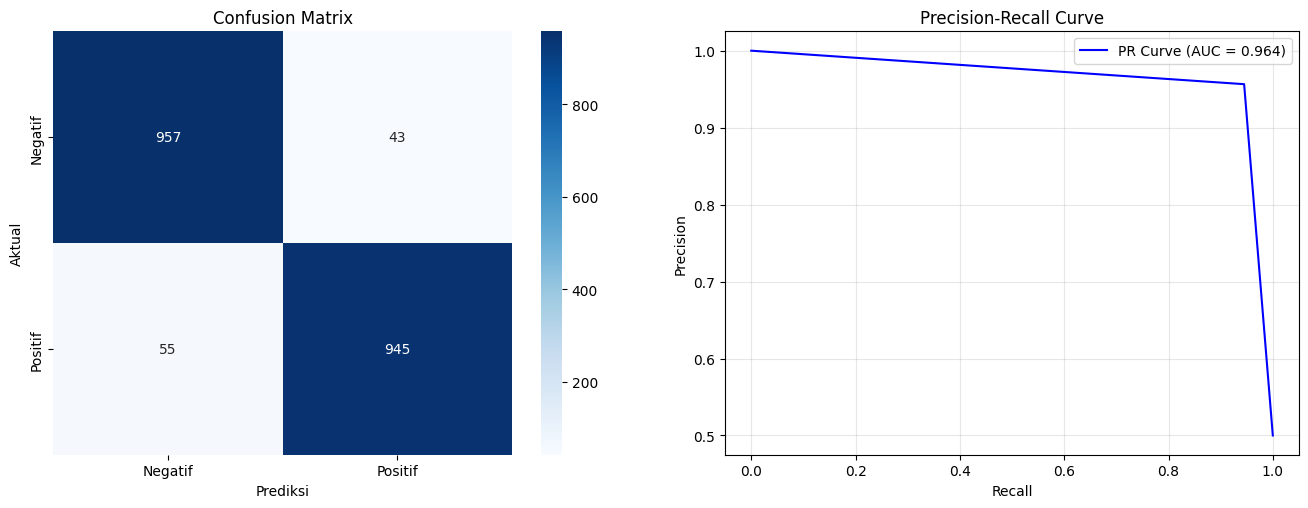


=== METRIK MODEL TERBAIK ===
Accuracy: 0.95100
Precision: 0.95106
Recall: 0.95100
F1 Score: 0.95100
PR AUC: 0.96449


In [ ]:
# Section 9: Visualisasi Confusion Matrix dan Precision-Recall Curve

# Menampilkan Confusion Matrix dan Precision-Recall Curve untuk model terbaik
if best_global_model is not None and len(best_trial_predictions['labels']) > 0:
    print("\n=== VISUALISASI HASIL MODEL TERBAIK FASILITAS BAYESIAN OPTIMIZATION IndoBERT ===")

    all_labels = best_trial_predictions['labels']
    all_preds = best_trial_predictions['preds']

    # Menampilkan Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(14, 6))

    # Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negatif', 'Positif'],
                yticklabels=['Negatif', 'Positif'])
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.title(f'Confusion Matrix')

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)

    # Binarkan label untuk dua kelas
    y_true_bin = label_binarize(all_labels, classes=[0, 1])
    y_pred_bin = label_binarize(all_preds, classes=[0, 1])

    # Menghitung precision-recall
    precision, recall, _ = precision_recall_curve(y_true_bin.ravel(), y_pred_bin.ravel())
    pr_auc = auc(recall, precision)

    plt.plot(recall, precision, color='b', label=f'PR Curve (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)

    plt.subplots_adjust(wspace=0.4)
    plt.tight_layout(pad=4.0)
    plt.show()

    # Menampilkan metrik detail
    accuracy = accuracy_score(all_labels, all_preds)
    precision_score_val = precision_score(all_labels, all_preds, average='weighted')
    recall_score_val = recall_score(all_labels, all_preds, average='weighted')
    f1_score_val = f1_score(all_labels, all_preds, average='weighted')

    print(f"\n=== METRIK MODEL TERBAIK ===")
    print(f"Accuracy: {accuracy:.5f}")
    print(f"Precision: {precision_score_val:.5f}")
    print(f"Recall: {recall_score_val:.5f}")
    print(f"F1 Score: {f1_score_val:.5f}")
    print(f"PR AUC: {pr_auc:.5f}")

else:
    print("Model terbaik tidak tersedia untuk visualisasi.")
